In [146]:
from tf_chpvk_pv.dataset import *
import matplotlib.pyplot as plt
import pandas as pd

df = create_dataset()

train_df, test_df = train_test_split_()

2025-04-01 11:34:20.671 | INFO     | tf_chpvk_pv.dataset:create_dataset:39 - Processing dataset...
2025-04-01 11:34:21.769 | SUCCESS  | tf_chpvk_pv.dataset:create_dataset:164 - Processing dataset complete.
2025-04-01 11:34:21.809 | INFO     | tf_chpvk_pv.dataset:train_test_split_:178 - Creating train and test dataset...
2025-04-01 11:34:21.824 | SUCCESS  | tf_chpvk_pv.dataset:train_test_split_:212 - Creating train and test dataset complete.


In [147]:
from tf_chpvk_pv.modeling.train import *

train_df, test_df, tolerance_factor_dict = evaluate_t_sisso('')

In [148]:
df = pd.concat([train_df, test_df])
df['type'] = 'Halogen'
df.loc[df.rX == 184.4, 'type'] = 'Chalcogen'
df.loc[df.rX == 198.14, 'type'] = 'Chalcogen'
df.loc[df['exp_label'] == 1, 'stab'] = 'Stable PVK'
df.loc[df['exp_label'] == 0, 'stab'] = 'Unstable PVK'

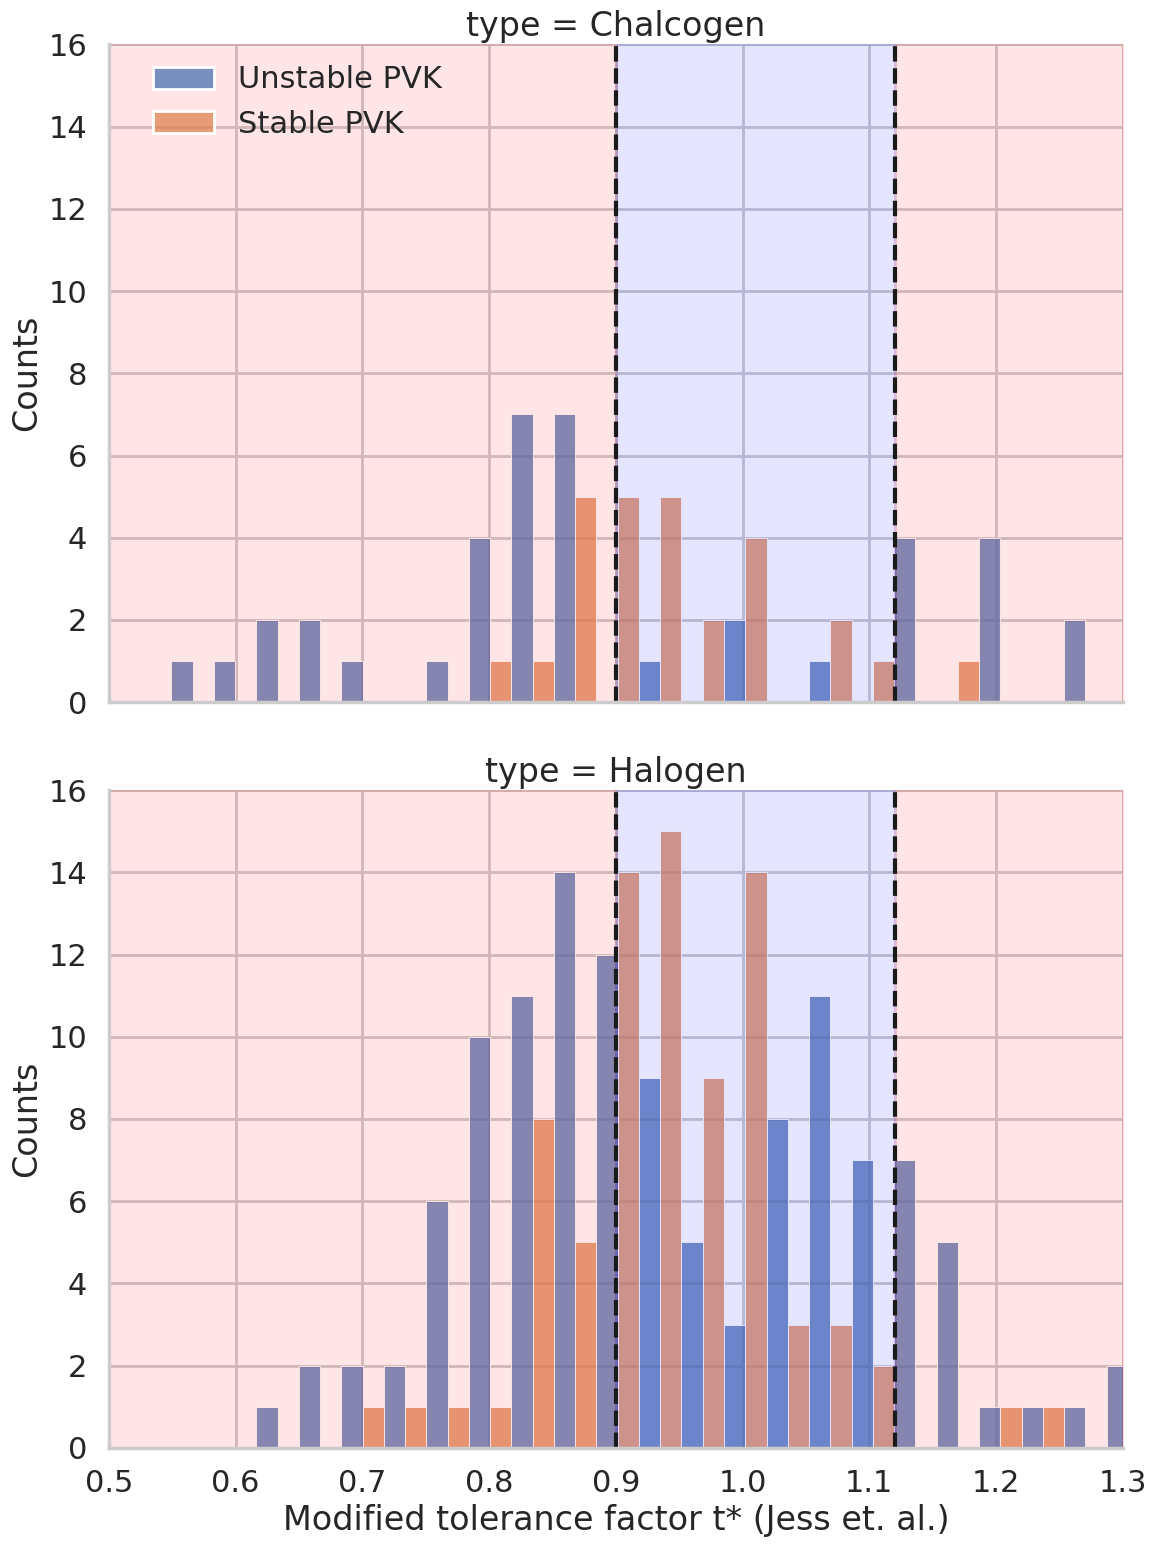

In [149]:
import seaborn as sns
from tf_chpvk_pv.config import FIGURES_DIR

sns.set_context("poster")
fg = sns.displot(data=df, x='t_jess', hue='stab',
                row='type', bins=50, 
                stat='count', height=8,
                multiple='dodge', aspect=1.5)



#sns.histplot(data=df, x='t_jess', hue=['exp_label', 'type'], bins=50, stat='percent', common_norm=False, multiple='dodge')
#sns.histplot(data=df[df['exp_label'] == 0], x='t_jess', hue='type', bins=50, stat='percent', common_norm=False, multiple='dodge')

xlims = [0.5, 1.3]
ylims = [0, 16]
th = [0.9, 1.12]

fg.refline(x=th[0], color='k', linestyle='--')
fg.refline(x=th[1], color='k', linestyle='--')

for ax in fg.axes:
    ax[0].fill_between([xlims[0],th[0]], ylims[0], ylims[1], color='red', alpha=0.1)
    ax[0].fill_between([th[0], th[1]], ylims[0], ylims[1], color='blue', alpha=0.1)
    ax[0].fill_between([th[1], xlims[1]], ylims[0], ylims[1], color='red', alpha=0.1)

plt.xlim(xlims)
plt.ylim(ylims)
sns.move_legend(fg, "upper left", title=None, frameon=False,
                bbox_to_anchor=(0.1, 0.96))

fg.set_axis_labels(x_var='Modified tolerance factor t* (Jess et. al.)', y_var='Counts')
fg.savefig(FIGURES_DIR / 'hist_dataset.png', dpi=600)

In [150]:
from tf_chpvk_pv.config import CRABNET_DIR
import pandas as pd

pvk_path = 'data/perovskite_bandgap_devices.csv'
pvkch_path = 'data/chalcogenides_bandgap_devices.csv'
ch_path = 'data/chalcogen_semicon_bandgap.csv'
path_data_grouped = 'data/df_grouped_formula_complete_dataset.csv'

df_pvk = pd.read_csv(CRABNET_DIR / pvk_path)
df_chalcogenides = pd.read_csv(CRABNET_DIR / pvkch_path)
df_chalc_semicon = pd.read_csv(CRABNET_DIR / ch_path)
for df_, sc in zip([df_pvk, df_chalcogenides, df_chalc_semicon], ['halide perovskite', 'chalcogenide perovskite', 'chalcogenide semiconductor']):
    df_['source'] = sc
df = pd.concat([df_pvk, df_chalcogenides, df_chalc_semicon])

df.rename(columns={'reduced_formulas':'formula'}, inplace=True)
df_grouped = pd.read_csv(CRABNET_DIR / path_data_grouped)


In [151]:
for formula in df_grouped['formula']:
    if df['formula'].str.contains(formula, regex=False).any():
        df_grouped.loc[df_grouped['formula'] == formula, 'source'] = df.loc[df['formula'] == formula, 'source'].values[0]
    else:
        print(formula)

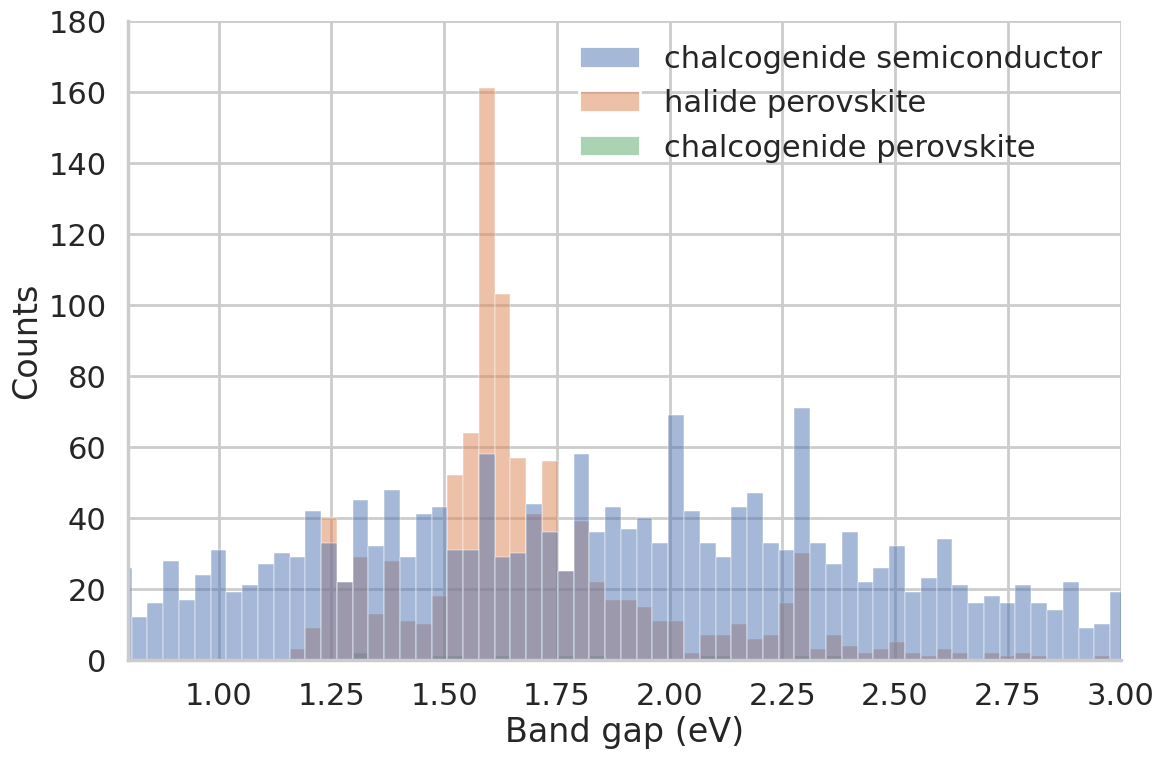

In [152]:
from tf_chpvk_pv.config import FIGURES_DIR
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("poster")

fg = sns.displot(data=df_grouped, x='target', hue='source', bins=200, 
                stat='count', height=8,
                #multiple='dodge',
                aspect=1.5)

sns.move_legend(fg, "upper left", title=None, frameon=False,
                bbox_to_anchor=(0.33, 0.96))

plt.xlim([0.8,3])
plt.ylim([0,180])
fg.set_axis_labels(x_var='Band gap (eV)', y_var='Counts')
fg.savefig(FIGURES_DIR / 'hist_dataset_Eg.png', dpi=600)

In [153]:
import pandas as pd
import seaborn as sns

df_crab = pd.read_csv('/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/crabnet/data/predicted_Eg_chl_pvk.csv')
df_modn = pd.read_csv('/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/modnet/data/predicted_Eg_chl_pvk.csv')

df_crab.rename(columns={'formula':'material',
                        'bandgap':'Eg',
                        'bandgap_sigma':'sigma-CrabNet'},
                inplace=True)

df_crab['source'] = 'CrabNet'
df_modn['source'] = 'ModNet'

df_modn.rename(columns={'gap_expt_eV':'Eg'}, inplace=True)
df_modn.drop(columns=['Unnamed: 0'], inplace=True)
df = pd.concat([df_crab, df_modn])

# Regex pattern to extract A, B, and X
pattern = r'^([A-Z][a-z]?)([A-Z][a-z]?)([A-Z][a-z]?)?3$'

# Apply regex and store results in new columns
df[['A', 'B', 'X']] = df['material'].str.extract(pattern)

df['material_label'] = ['$' + x.replace('3', '_3$') for x in df['material']]

In [154]:

def plot_bars_Eg(data, anion='S'):

    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_context('poster')

    df = data.copy()

    df = df[df['Eg'] > 0]
    df = df[df['X'] == anion]

    size_y = df.shape[0] / 3.5


    plt.figure(figsize=(15,size_y))

    sns.barplot(df[df.X == anion], x='Eg', y='material_label', hue='source')
    th = [0.8, 1.8]

    plt.axvline(x=th[0], color='k', linestyle='--')
    plt.axvline(x=th[1], color='k', linestyle='--')

    plt.xlabel('Bandgap (eV)')
    plt.ylabel('')
    plt.show()


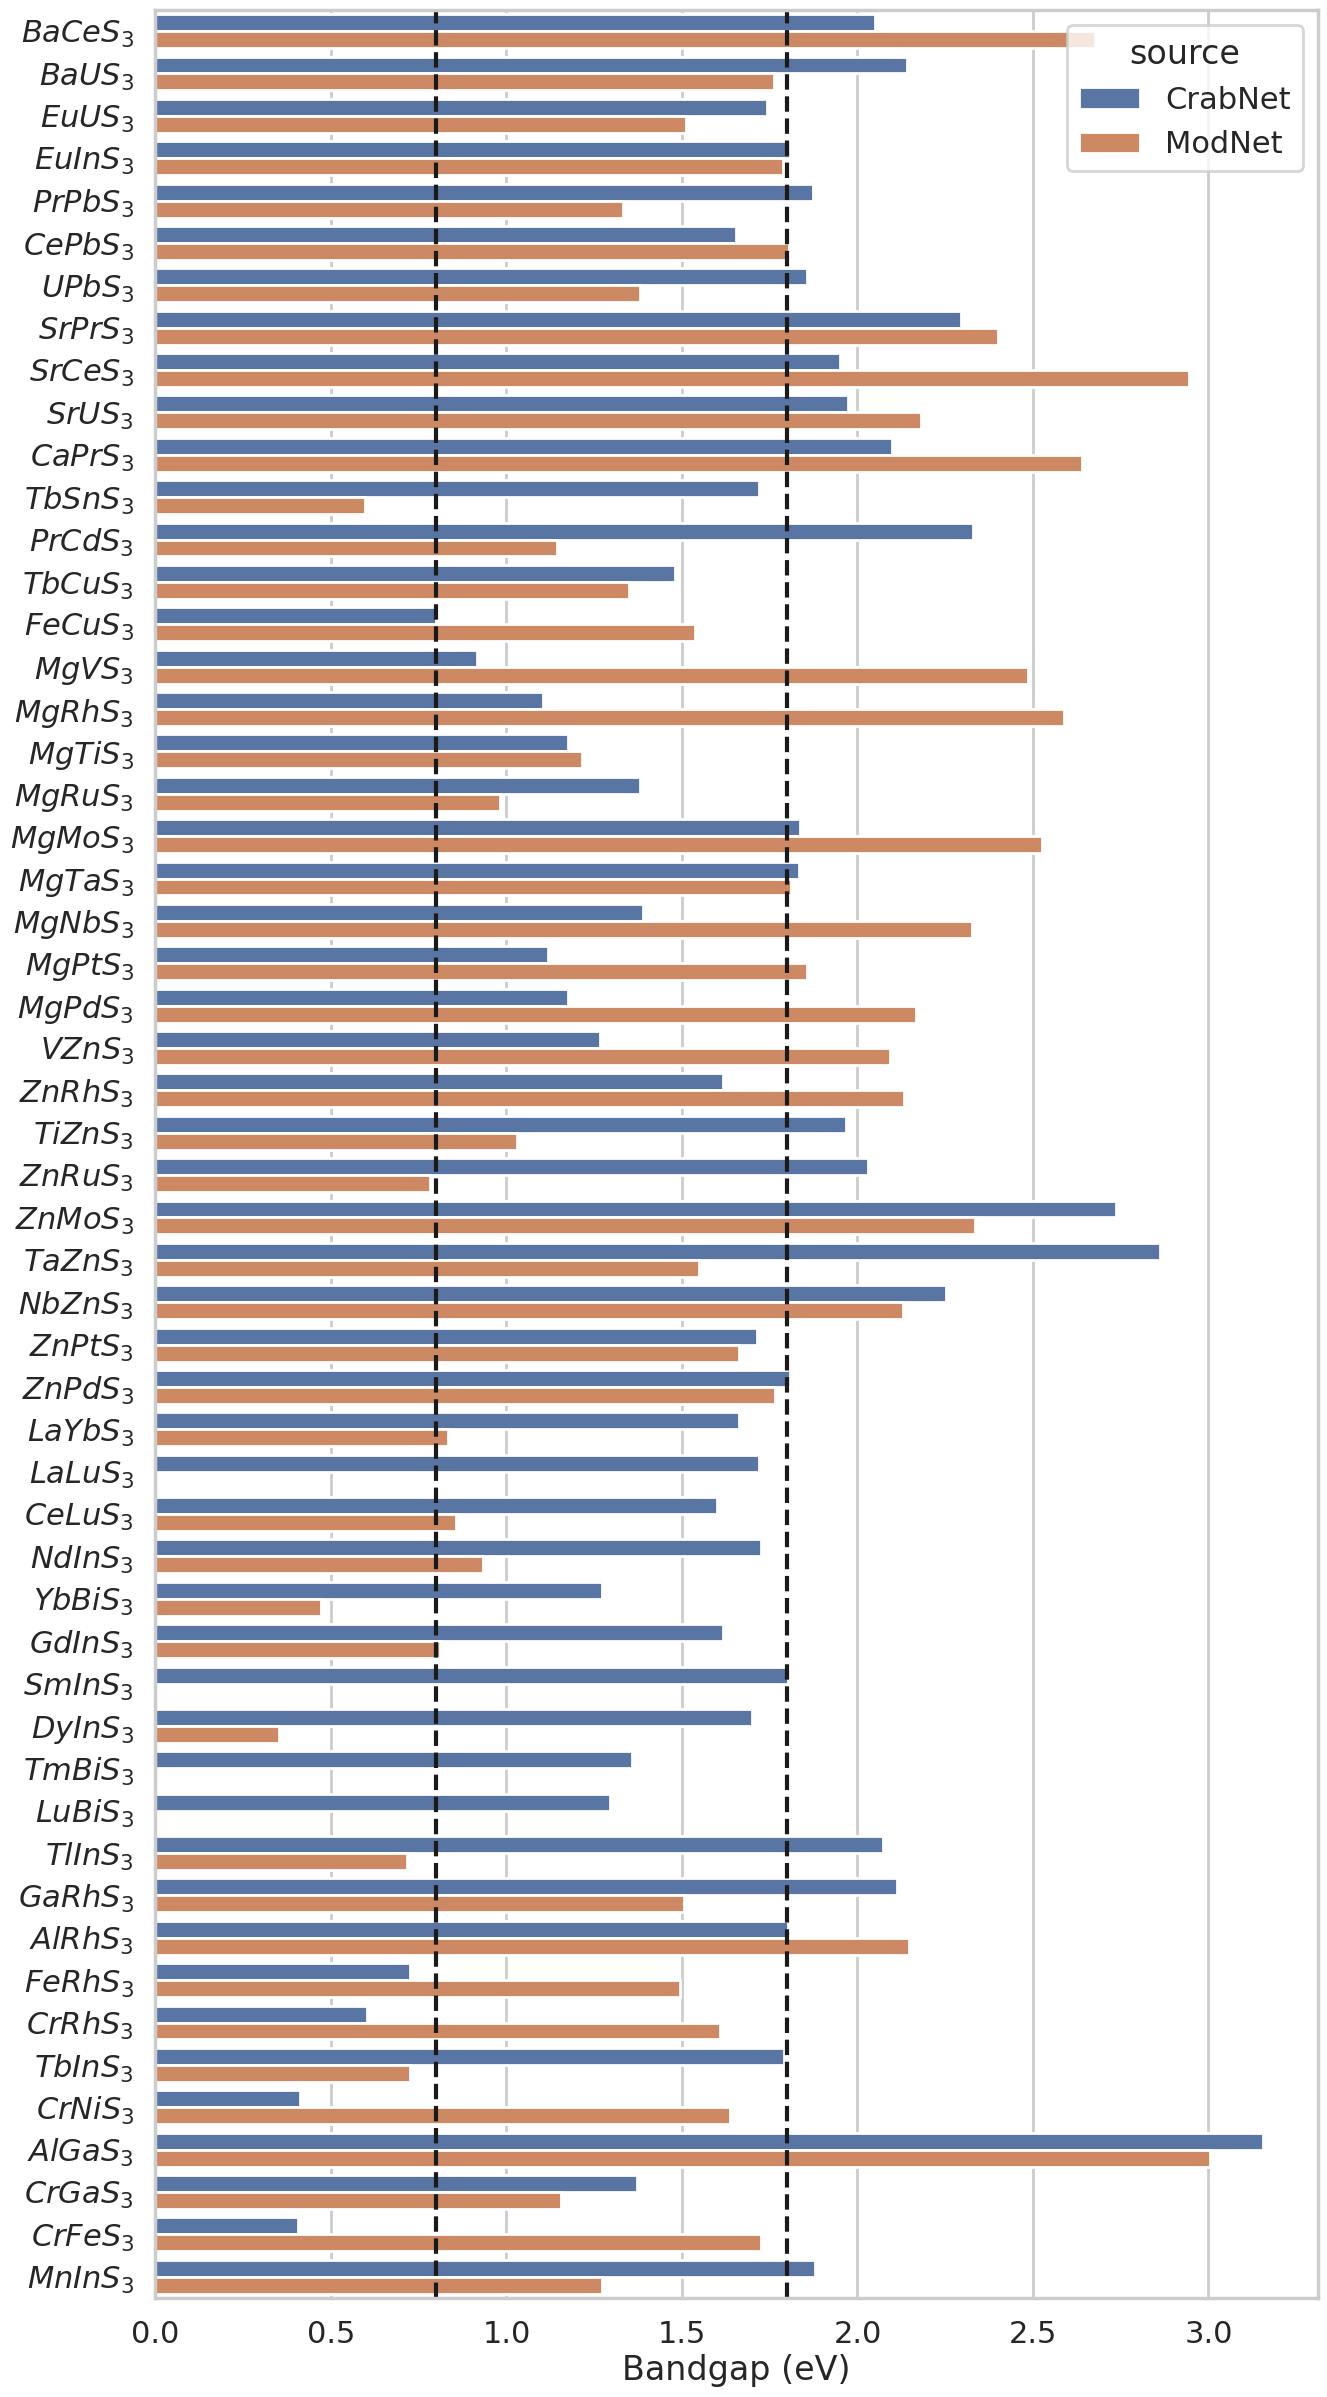

In [155]:
plot_bars_Eg(df, 'S')

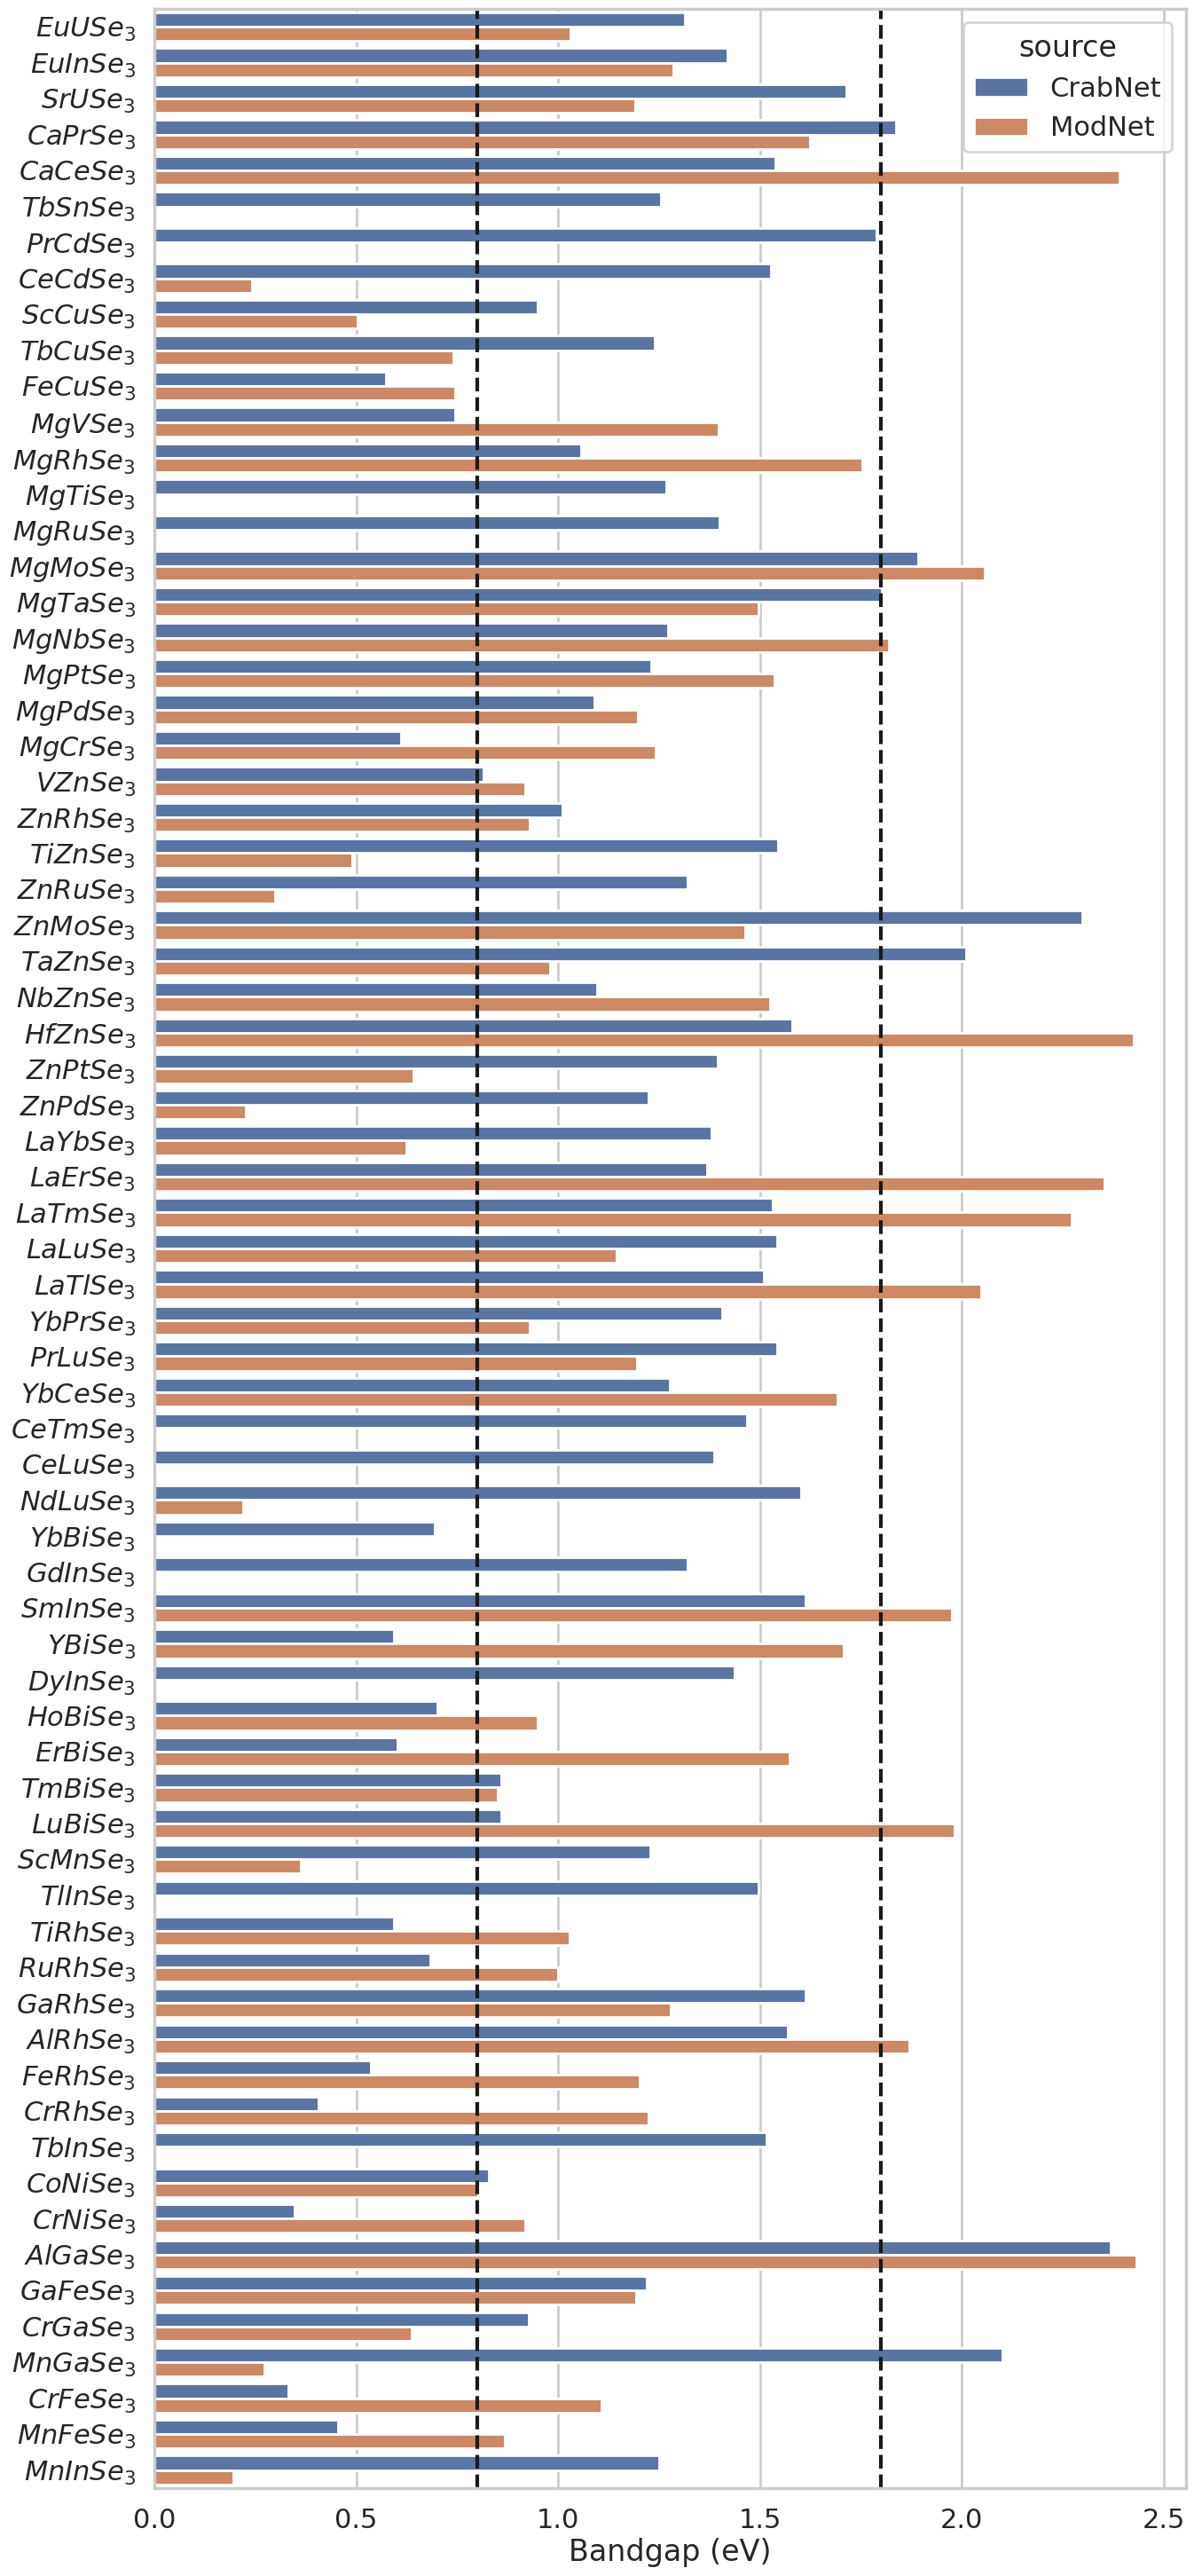

In [156]:
plot_bars_Eg(df, 'Se')

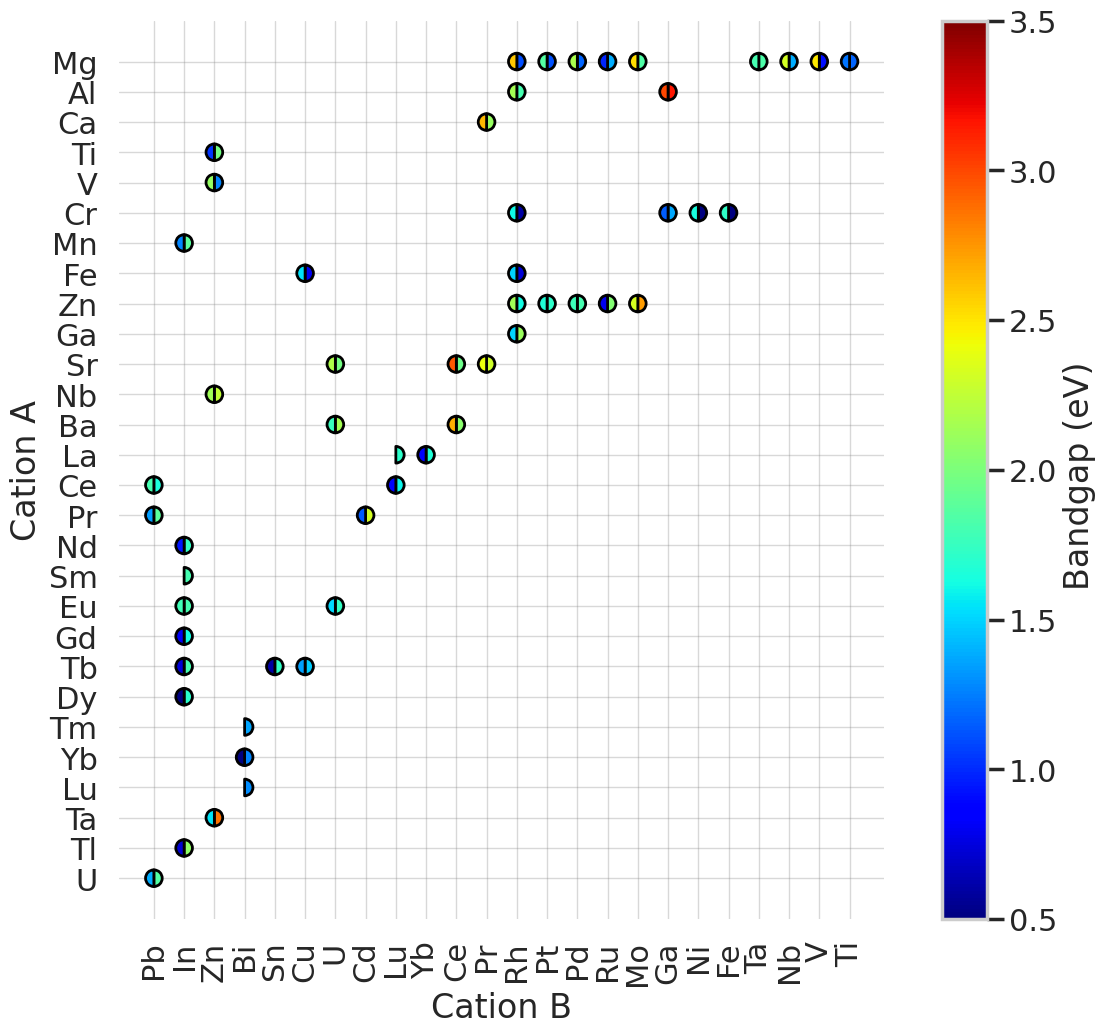

In [157]:
def plot_matrix(df_out, anion='S'):


    import matplotlib.pyplot as plt
    from matplotlib.markers import MarkerStyle
    from tf_chpvk_pv.config import FIGURES_DIR

    import numpy as np
    import seaborn as sns

    element_to_number = {
    "H": 1, "He": 2, "Li": 3, "Be": 4, "B": 5, "C": 6, "N": 7, "O": 8, "F": 9, "Ne": 10,
    "Na": 11, "Mg": 12, "Al": 13, "Si": 14, "P": 15, "S": 16, "Cl": 17, "Ar": 18, "K": 19, "Ca": 20,
    "Sc": 21, "Ti": 22, "V": 23, "Cr": 24, "Mn": 25, "Fe": 26, "Co": 27, "Ni": 28, "Cu": 29, "Zn": 30,
    "Ga": 31, "Ge": 32, "As": 33, "Se": 34, "Br": 35, "Kr": 36, "Rb": 37, "Sr": 38, "Y": 39, "Zr": 40,
    "Nb": 41, "Mo": 42, "Tc": 43, "Ru": 44, "Rh": 45, "Pd": 46, "Ag": 47, "Cd": 48, "In": 49, "Sn": 50,
    "Sb": 51, "Te": 52, "I": 53, "Xe": 54, "Cs": 55, "Ba": 56, "La": 57, "Ce": 58, "Pr": 59, "Nd": 60,
    "Pm": 61, "Sm": 62, "Eu": 63, "Gd": 64, "Tb": 65, "Dy": 66, "Ho": 67, "Er": 68, "Tm": 69, "Yb": 70,
    "Lu": 71, "Hf": 72, "Ta": 73, "W": 74, "Re": 75, "Os": 76, "Ir": 77, "Pt": 78, "Au": 79, "Hg": 80,
    "Tl": 81, "Pb": 82, "Bi": 83, "Po": 84, "At": 85, "Rn": 86, "Fr": 87, "Ra": 88, "Ac": 89, "Th": 90,
    "Pa": 91, "U": 92, "Np": 93, "Pu": 94, "Am": 95, "Cm": 96, "Bk": 97, "Cf": 98, "Es": 99, "Fm": 100,
    "Md": 101, "No": 102, "Lr": 103, "Rf": 104, "Db": 105, "Sg": 106, "Bh": 107, "Hs": 108, "Mt": 109,
    "Ds": 110, "Rg": 111, "Cn": 112, "Nh": 113, "Fl": 114, "Mc": 115, "Lv": 116, "Ts": 117, "Og": 118
    }


    df_out = df_out[df_out['X'] == anion]
    df_out = df_out[df_out['Eg'] > 0]
    df_out['Z_A'] = df_out.A.map(element_to_number)
    df_out['Z_B'] = df_out.B.map(element_to_number)

    df_out.sort_values(by=['Z_A', 'Z_B'], inplace=True, ascending=False)

    sns.set_theme(style="whitegrid")
    sns.set_context('poster')

    df_crab = df_out[df_out['source'] == 'CrabNet']
    df_modn = df_out[df_out['source'] == 'ModNet']

    fsize = df_crab.nunique()['A'] / 2.4

    fig, ax = plt.subplots(figsize=(15,fsize))

    cmap_ = 'jet'

    im1 = ax.scatter(df_crab.B, df_crab.A, c=df_crab.Eg,
                     edgecolor="black", vmin=0.5, vmax=3.5,
                     marker=MarkerStyle("o", fillstyle="right"), cmap=cmap_)
    im2 = ax.scatter(df_modn.B, df_modn.A, c=df_modn.Eg, 
                     edgecolor="black", vmin=0.5, vmax=3.5,
                     marker=MarkerStyle("o", fillstyle="left"), cmap=cmap_)
    cbar1 = plt.colorbar(im1, ax=ax)
    cbar1.set_label("Bandgap (eV) ", rotation=90)


    plt.title('')

    # Tweak the figure to finalize
    ax.set(xlabel="Cation B", ylabel="Cation A", aspect="equal")

    plt.xticks(rotation=90)
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.3)
    ax.set_frame_on(False)

    name_file = 'bandgap_crabnet+modnet_' + anion + '.png'

    plt.savefig(FIGURES_DIR / name_file, dpi=600)


    plt.show()


plot_matrix(df,  anion='S')

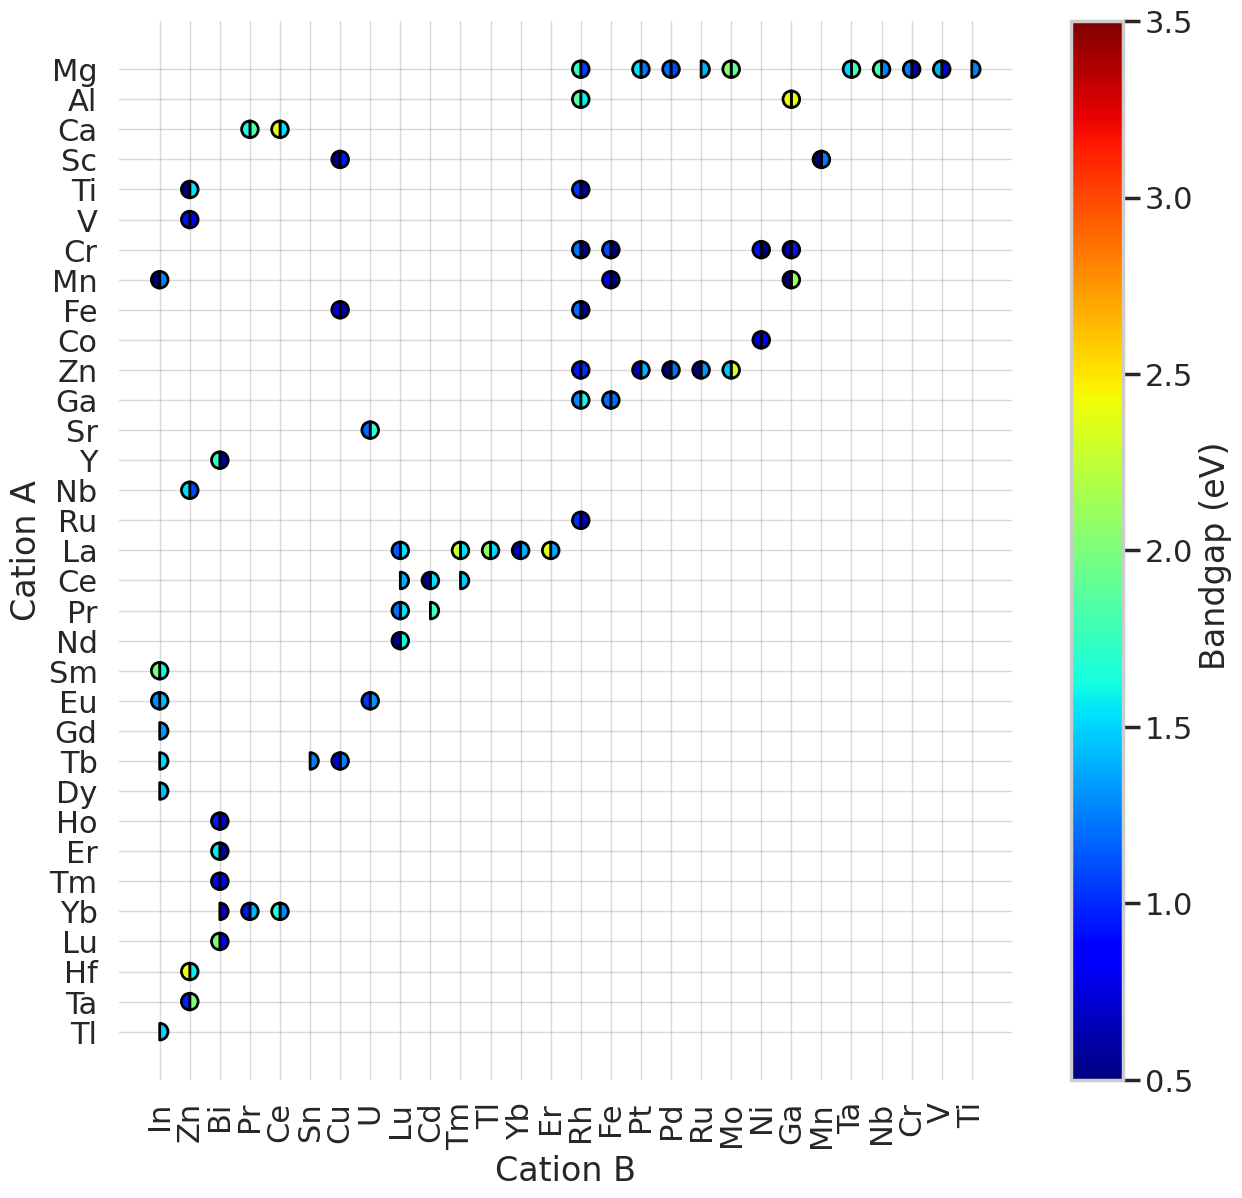

In [158]:
plot_matrix(df,  anion='Se')